In [24]:
import os
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import plotly.graph_objects as go
import alpaca_trade_api as tradeapi
from utils.MCForecastTools import MCSimulation
import warnings
warnings.filterwarnings('ignore')
import math
import matplotlib.pyplot as plt


from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame
from datetime import datetime


In [2]:
# Load the environment variables from the .env file
#by calling the load_dotenv function
load_dotenv('api.env')

True

In [3]:
# Set the variables for the Alpaca API and secret keys
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca tradeapi.REST object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

In [4]:
# creates directory for output data if it doesn't exist
directory = "output_data"
if not os.path.exists(directory):
    os.makedirs(directory)

In [5]:
# use this cell to get the risk level from the questionary
# for now I'm using high as default

risk = "high"

In [6]:
SPDR_sectors = ["XLC", "XLY", "XLP", "XLE", "XLF", "XLV", "XLI", "XLB", "XLRE", "XLK", "XLU", "SPY"]

In [7]:
# Format current date as ISO format
# Set both the start and end date at the date of your prior weekday 
# This will give you the closing price of the previous trading day
# Alternatively you can use a start and end date of 2020-08-07
start_date = pd.Timestamp("2018-07-01", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2023-05-04", tz="America/New_York").isoformat()

In [8]:

# add cryptos
# maybe make a script


In [9]:
# Use the Alpaca get_bars function to get current closing prices the portfolio
# Be sure to set the `df` property after the function to format the response object as a DataFrame
ticker_data = api.get_bars(
    SPDR_sectors,
    "1Day",
    start=start_date,
    end=end_date
).df

display(ticker_data)
ticker_data.to_csv("./output_data/ticker_data.csv", sep=',', header=True, encoding="utf-8")

,open,high,low,close,volume,trade_count,vwap,symbol
timestamp,,,,,,,,
2018-07-02 04:00:00+00:00,269.51,272.0400,269.240,271.84,63769156,279127,270.689557,SPY
2018-07-03 04:00:00+00:00,272.87,272.9800,270.420,270.88,42201071,180591,271.716151,SPY
2018-07-05 04:00:00+00:00,272.17,273.1800,270.960,273.02,57441049,260592,272.247814,SPY
2018-07-06 04:00:00+00:00,273.14,275.8400,272.715,275.36,66693896,269826,274.929843,SPY
2018-07-09 04:00:00+00:00,276.55,277.9600,276.500,277.90,51771719,212828,277.260701,SPY
...,...,...,...,...,...,...,...,...
2023-04-28 04:00:00+00:00,146.79,148.0609,145.415,147.86,3691034,57745,147.097681,XLY
2023-05-01 04:00:00+00:00,147.50,147.8200,146.190,146.40,4273877,47655,146.909069,XLY
2023-05-02 04:00:00+00:00,146.18,146.8700,144.770,146.55,4608577,59457,146.006500,XLY


In [10]:
# Reorganize the DataFrame
# Separate ticker data
#SPDR_sectors = ["XLC", "XLY", "XLP", "XLE", "XLF", "XLV", "XLI", "XLB", "XLRE", "XLK", "XLU"]

# communications
XLC = ticker_data[ticker_data['symbol']=='XLC'].drop('symbol', axis=1)
# consumer discrestionary
XLY = ticker_data[ticker_data['symbol']=='XLY'].drop('symbol', axis=1)
# consumer staples
XLP = ticker_data[ticker_data['symbol']=='XLP'].drop('symbol', axis=1)
# energy
XLE = ticker_data[ticker_data['symbol']=='XLE'].drop('symbol', axis=1)
# finacial
XLF = ticker_data[ticker_data['symbol']=='XLF'].drop('symbol', axis=1)
# healthcare
XLV = ticker_data[ticker_data['symbol']=='XLV'].drop('symbol', axis=1)
# industrials
XLI = ticker_data[ticker_data['symbol']=='XLI'].drop('symbol', axis=1)
# materials
XLB = ticker_data[ticker_data['symbol']=='XLB'].drop('symbol', axis=1)
# real estate
XLRE = ticker_data[ticker_data['symbol']=='XLRE'].drop('symbol', axis=1)
# tech
XLK = ticker_data[ticker_data['symbol']=='XLK'].drop('symbol', axis=1)
# utilities
XLU = ticker_data[ticker_data['symbol']=='XLU'].drop('symbol', axis=1)
# SPY
SPY = ticker_data[ticker_data['symbol']=='SPY'].drop('symbol', axis=1)

# Concatenate the ticker DataFrames
ticker_data = pd.concat([XLC, XLY, XLP, XLE, XLF, XLV, XLI, XLB, XLRE, XLK, XLU, SPY],
                axis=1, 
                keys=["XLC", "XLY", "XLP", "XLE", "XLF", "XLV", "XLI", "XLB", "XLRE", "XLK", "XLU", "SPY"]
)

XLC_close = ticker_data["XLC"].filter(['close'])
XLY_close = ticker_data["XLY"].filter(['close'])
XLP_close = ticker_data["XLP"].filter(['close'])
XLE_close = ticker_data["XLE"].filter(['close'])
XLF_close = ticker_data["XLF"].filter(['close'])
XLV_close = ticker_data["XLV"].filter(['close'])
XLI_close = ticker_data["XLI"].filter(['close'])
XLB_close = ticker_data["XLB"].filter(['close'])
XLRE_close = ticker_data["XLRE"].filter(['close'])
XLK_close = ticker_data["XLK"].filter(['close'])
XLU_close = ticker_data["XLU"].filter(['close'])
SPY_close = ticker_data["SPY"].filter(['close'])

close_data_all = pd.concat([XLC_close, XLY_close, XLP_close, XLE_close, XLF_close, XLV_close, XLI_close, XLB_close, XLRE_close, XLK_close, XLU_close, SPY_close],
                axis=1, 
                keys=["XLC", "XLY", "XLP", "XLE", "XLF", "XLV", "XLI", "XLB", "XLRE", "XLK", "XLU", "SPY"]
)

display(close_data_all)
close_data_all.to_csv("./output_data/close_data_all.csv", sep=",", header=True, encoding="utf-8")

,XLC,XLY,XLP,XLE,XLF,XLV,XLI,XLB,XLRE,XLK,XLU,SPY
,close,close,close,close,close,close,close,close,close,close,close,close
timestamp,,,,,,,,,,,,
2018-07-02 04:00:00+00:00,49.8400,109.45,51.25,74.79,26.72,83.72,71.78,57.81,32.52,70.09,52.33,271.84
2018-07-03 04:00:00+00:00,49.2300,108.90,51.35,75.12,26.46,83.92,71.56,57.66,32.71,69.26,52.48,270.88
2018-07-05 04:00:00+00:00,49.9799,109.44,52.07,75.21,26.53,84.80,71.89,58.16,33.14,70.24,52.78,273.02
2018-07-06 04:00:00+00:00,50.7700,110.30,52.22,75.67,26.67,86.01,72.16,58.45,33.28,71.06,53.17,275.36
2018-07-09 04:00:00+00:00,51.0600,111.62,52.02,76.82,27.29,86.60,73.48,58.98,32.97,71.60,51.53,277.90
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-28 04:00:00+00:00,59.9000,147.86,77.44,85.13,33.17,133.53,100.00,80.55,37.75,150.83,68.98,415.93
2023-05-01 04:00:00+00:00,59.8900,146.40,77.50,84.17,33.08,134.22,100.54,80.51,37.40,150.92,69.10,415.51


<AxesSubplot:title={'center':'Sectors pct changes'}>

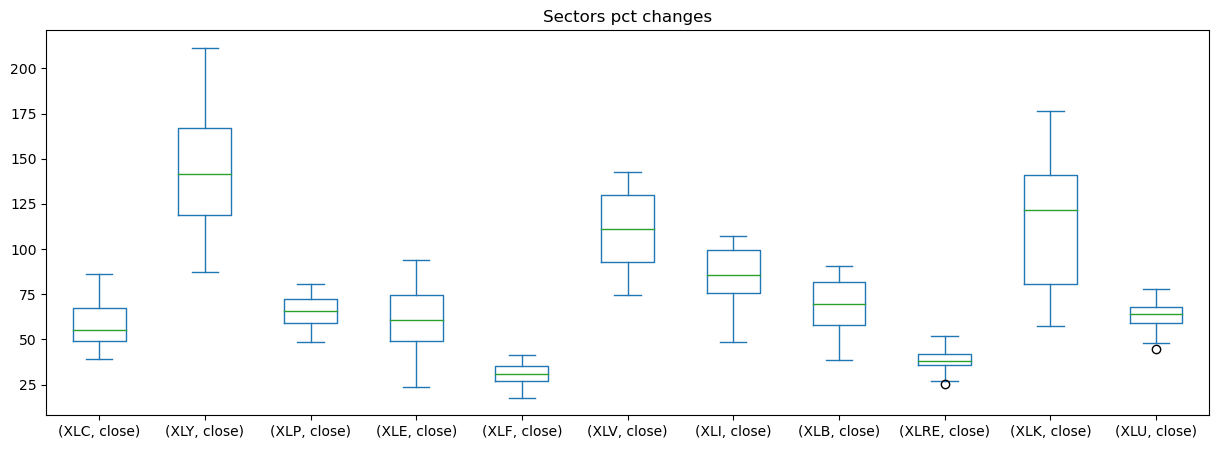

In [28]:
close_data = close_data_all.drop(["SPY"], axis=1)
close_data_fig = close_data.plot(kind='box', title = "Sectors pct changes", figsize=(15, 5))
plt.savefig("./output_data/close_data_plot.png")
close_data_fig

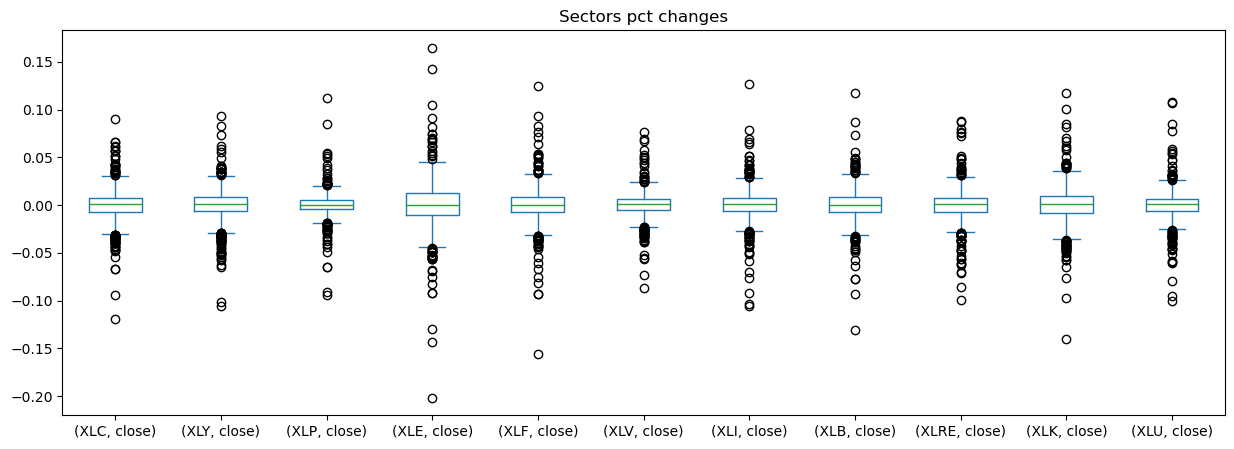

In [27]:
close_data_returns = close_data.pct_change()
close_data_returns_fig = close_data_returns.plot(kind='box', title = "Sectors pct changes", figsize=(15, 5))
plt.savefig("./output_data/close_data_returns_plot.png")

In [ ]:
# STD 

close_data_std = close_data_returns.std()
annualized_close_data_std = close_data_std * math.sqrt(252)
display(annualized_close_data_std.sort_values())

annualized_close_data_std.to_csv("./output_data/annualized_close_data_std.csv", sep=',', enconding="utf-8")

#rolling_close_data_std = close_data_returns.rolling(21).std()
#rolling_close_data_std.plot(
#    legend=True, figsize=(15, 10), title="Rolling std 21")


In [ ]:
# SHARPE RATIOS

annual_avg_returns_df = close_data_returns.mean() * 252
annual_avg_returns_df.sort_values()

close_sharpe_ratios_df = annual_avg_returns_df / annualized_close_data_std
display(close_sharpe_ratios_df.sort_values())

close_sharpe_ratios_df.to_csv("./output_data/close_sharpe_ratios.csv", sep=',', encoding="utf-8")

In [ ]:
# BETA

SP500_variance_df = close_data_all["SPY"].rolling(60).var()
SP500_variance_df.tail()

SP500_variance_df.to_csv("./output_data/SP500_variance.csv", sep=',', encoding="utf-8")

In [ ]:
# Energy
XLE_COvariance_df = close_data["XLE"].rolling(60).cov(close_data_all["SPY"])
XLE_Beta_df = XLE_COvariance_df / SP500_variance_df

# Real Estate
XLRE_COvariance_df = close_data["XLRE"].rolling(60).cov(close_data_all["SPY"])
XLRE_Beta_df = XLRE_COvariance_df / SP500_variance_df

# Communications
XLC_COvariance_df = close_data["XLC"].rolling(60).cov(close_data_all["SPY"])
XLC_Beta_df = XLC_COvariance_df / SP500_variance_df

# Financial
XLF_COvariance_df = close_data["XLF"].rolling(60).cov(close_data_all["SPY"])
XLF_Beta_df = XLF_COvariance_df / SP500_variance_df

# cons discretionary
XLY_COvariance_df = close_data["XLY"].rolling(60).cov(close_data_all["SPY"])
XLY_Beta_df = XLY_COvariance_df / SP500_variance_df

# utilities
XLU_COvariance_df = close_data["XLU"].rolling(60).cov(close_data_all["SPY"])
XLU_Beta_df = XLU_COvariance_df / SP500_variance_df

# Materials
XLB_COvariance_df = close_data["XLB"].rolling(60).cov(close_data_all["SPY"])
XLB_Beta_df = XLB_COvariance_df / SP500_variance_df

# Industrials
XLI_COvariance_df = close_data["XLI"].rolling(60).cov(close_data_all["SPY"])
XLI_Beta_df = XLI_COvariance_df / SP500_variance_df

# Communications
XLP_COvariance_df = close_data["XLP"].rolling(60).cov(close_data_all["SPY"])
XLP_Beta_df = XLP_COvariance_df / SP500_variance_df

# Financial
XLV_COvariance_df = close_data["XLV"].rolling(60).cov(close_data_all["SPY"])
XLV_Beta_df = XLV_COvariance_df / SP500_variance_df

# cons discretionary
XLK_COvariance_df = close_data["XLK"].rolling(60).cov(close_data_all["SPY"])
XLK_Beta_df = XLK_COvariance_df / SP500_variance_df

Beta_df = pd.concat([XLE_Beta_df, XLRE_Beta_df, XLC_Beta_df, XLF_Beta_df, XLY_Beta_df, XLU_Beta_df, XLB_Beta_df, XLI_Beta_df, XLP_Beta_df, XLV_Beta_df, XLK_Beta_df], 
                axis=1, 
                keys=["XLE", "XLRE", "XLC", "XLF", "XLY", "XLU", "XLB", "XLI", "XLP", "XLV", "XLK"])

Beta_df.tail()

Beta_df.to_csv("./output_data/Beta.csv", sep=',', header=True, encoding="utf-8")

In [ ]:
# Set the tickers for both the bond and stock portion of the portfolio
if risk == "high":
    tickers = ["XLK", "XLV", "XLY", "XLE", "TMF", "TYD"]
    
elif risk == "mid":
    tickers = ["XLC", "XLU", "XLB", "XLP", "TLT", "IEF"]
    
elif risk == "low":
    tickers = ["XLRE", "XLF", "XLI", "SHY", "AGG"]

# Set timeframe to 1Day
timeframe = "1Day"

In [ ]:
# Use the hvplot to plot the close for each ticker
if risk == "high":
    MC_simulation = MCSimulation(
        portfolio_data=close_data,
        weights=[0.15, 0.15, 0.15, 0.15,0.20, 0.20],
        num_simulation=500,
        num_trading_days=252*10,
    )

if risk == "mid":
    MC_simulation = MCSimulation(
        portfolio_data=close_data,
        weights=[0.15, 0.15, 0.15, 0.15, 0.20, 0.20],
        num_simulation=500,
        num_trading_days=252*10,
    )

if risk == "low":
    MC_simulation = MCSimulation(
        portfolio_data=close_data,
        weights=[0.20, 0.20, 0.20, 0.20, 0.20],
        num_simulation=500,
        num_trading_days=252*10,
    )

# Review the simulation input data
MC_simulation.portfolio_data.head()
MC_simulation.portfolio_data.to_csv("MC_simulation_portfolio.csv", sep=',', header=True, encoding="utf-8")

In [ ]:
MC_simulation.calc_cumulative_return()

In [ ]:
MC_simulation.plot_simulation()

In [ ]:
MC_simulation.plot_distribution()

In [ ]:
tbl = MC_simulation.summarize_cumulative_return()


# Review the 30-year Monte Carlo summary statistics
print(tbl)

In [ ]:
# efficient frontier - source: https://towardsdatascience.com/efficient-frontier-in-python-detailed-tutorial-84a304f03e79
annualized_cov = close_data_returns.cov() * 252
annualized_mean = (1+close_data_returns.mean())**252 - 1

mean_variance_pairs = []
    
# get mean variance pairs
for i in range(500):
    assets = np.random.choice(list(close_data.columns), 11, replace=False) # 11 different assets
    weights = np.random.rand(11)
    weights /= sum(weights)

    portfolio_var = 0
    portfolio_ret = 0
    for i in range(len(assets)):
        portfolio_ret += weights[i] * annualized_mean.loc[assets[i]]
        for j in range(len(assets)):
            portfolio_var += weights[i] * weights[j] * annualized_cov.loc[assets[i], assets[j]]

    mean_variance_pairs.append([portfolio_ret, portfolio_var])

# plot
mean_variance_pairs = np.array(mean_variance_pairs)
risk_free_rate = 0

fig = go.Figure()
fig.add_trace(go.Scatter(x=mean_variance_pairs[:,1]**0.5,
                         y=mean_variance_pairs[:,0],
                         marker=dict(color=mean_variance_pairs[:,0]-risk_free_rate)/(mean_variance_pairs[:,1]**0.5),
                         showscale=True,
                         size=10,
                         line=dict(width=1),
                         colorscale="RdBu",
                         colorbar=dict(title="Sharpe<br>Ratio")
                         ),
                        mode="markers")

fig.update_layout(template="plotly_white",
                  xaxis=dict(title="Annualised Risk (Volatility)"),
                  yaxis=dict(title="Annualised Return"),
                  title="Sharpe Ratio plot",
                  coloaxis_colorbar=dict(title="Sharpe Ratio"))